In [1]:
!pip install vit_keras -q

In [2]:
!pip install tensorflow-addons


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 5.6 MB/s eta 0:00:00


In [3]:
import os
import cv2
import sys
import random
import warnings
import numpy as np
import pandas as pd
from time import time
from itertools import chain
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.morphology import label
from skimage.io import imread, imshow, imread_collection, concatenate_images

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import (
    Dense, Input, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate,
    Activation, Add, multiply, add, concatenate, LeakyReLU, ZeroPadding2D, UpSampling2D,
    BatchNormalization, SeparableConv2D, Flatten )

from sklearn.metrics import classification_report
%matplotlib inline

from tensorflow.keras.applications import MobileNetV2

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
PATH = "gdrive/My Drive/Colab Notebooks/AML Project/chest_xray_reshuffle/"

In [6]:
#reading required files
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')
test_dir = os.path.join(PATH, 'test')

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Image dimensions expected by MobileNetV2
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Create ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
# Flow training images in batches using tf.keras.preprocessing.image.ImageDataGenerator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'  # or 'categorical' if you have more than two classes
)

# Flow validation images in batches using tf.keras.preprocessing.image.ImageDataGenerator
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Flow test images in batches using tf.keras.preprocessing.image.ImageDataGenerator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 4686 images belonging to 2 classes.
Found 585 images belonging to 2 classes.
Found 585 images belonging to 2 classes.


In [9]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.5 MB/s eta 0:00:00


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import Precision, Recall, AUC, BinaryAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, Callback
from tensorflow.keras import backend as K
from keras_tuner import RandomSearch

In [11]:
# Define metrics
precision_metric = Precision()
recall_metric = Recall()
auc_metric = AUC()
auc_pr_metric = AUC(curve='PR')

def F1Score(y_true, y_pred):
    precision = precision_metric(y_true, y_pred)
    recall = recall_metric(y_true, y_pred)
    f1_score = 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
    return f1_score

# Callbacks Setup
checkpoint = ModelCheckpoint('model-best-new-data.h5', save_best_only=True, monitor='val_accuracy', mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('training_log-new-data.csv')

class ResetStatesCallback(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        precision_metric.reset_states()
        recall_metric.reset_states()
        auc_metric.reset_states()
        auc_pr_metric.reset_states()



In [12]:
# Include the ResetStatesCallback in your callbacks list
reset_states_callback = ResetStatesCallback()

In [13]:
# Model Setup with MobileNetV2
def build_model(hp):
    base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu'),
        layers.Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            precision_metric,
            recall_metric,
            F1Score,
            auc_metric,
            auc_pr_metric
        ]
    )

    return model

In [14]:
from tensorflow.keras.applications import MobileNetV2

In [15]:
# Define the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='pneumonia_detection-new-data'
)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# Run the hyperparameter search
tuner.search(train_generator, epochs=3, validation_data=validation_generator, callbacks=[checkpoint, early_stopping, csv_logger, reset_states_callback])


Trial 9 Complete [00h 13m 07s]
val_accuracy: 0.9350427389144897

Best val_accuracy So Far: 0.9418803453445435
Total elapsed time: 02h 23m 59s

Search: Running Trial #10

Value             |Best Value So Far |Hyperparameter
384               |352               |units
0.3               |0.1               |dropout
0.001432          |0.00063273        |learning_rate

Epoch 1/3
147/147 [==============================] - 256s 2s/step - loss: 0.1949 - accuracy: 0.9272 - precision: 0.9484 - recall: 0.9520 - F1Score: 0.9120 - auc: 0.9683 - auc_1: 0.9838 - val_loss: 0.2375 - val_accuracy: 0.9197 - val_precision: 0.9095 - val_recall: 0.9883 - val_F1Score: 0.9548 - val_auc: 0.9702 - val_auc_1: 0.9843
Epoch 2/3
147/147 [==============================] - 264s 2s/step - loss: 0.0925 - accuracy: 0.9635 - precision: 0.9760 - recall: 0.9740 - F1Score: 0.9737 - auc: 0.9928 - auc_1: 0.9972 - val_loss: 0.1633 - val_accuracy: 0.9350 - val_precision: 0.9492 - val_recall: 0.9625 - val_F1Score: 0.9556 - val_au

In [17]:
# Get the best hyperparameters
best_hparams = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print("Best Hyperparameters:")
print(best_hparams)

Best Hyperparameters:
{'units': 352, 'dropout': 0.1, 'learning_rate': 0.0006327253334005014}


In [20]:
# Get the best hyperparameters
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
best_hparams = best_trial.hyperparameters.values
print("Best Hyperparameters:")
print(best_hparams)

Best Hyperparameters:
{'units': 352, 'dropout': 0.1, 'learning_rate': 0.0006327253334005014}


In [19]:


# Build the final model using the best hyperparameters
final_model = tuner.hypermodel.build(best_trial.hyperparameters)
final_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])


In [21]:
# Build the final model using the best hyperparameters
final_model_test = tuner.hypermodel.build(best_trial.hyperparameters)
final_model_test.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy', precision_metric,
            recall_metric,
            F1Score,
            auc_metric,
            auc_pr_metric])

In [22]:
# Train the final model
final_history_test = final_model_test.fit(
    train_generator,
    epochs=50,  # Adjust as needed
    validation_data=validation_generator,
    verbose=1
)

Epoch 1/50
147/147 [==============================] - 290s 2s/step - loss: 0.1461 - accuracy: 0.9437 - precision: 0.9520 - recall: 0.9685 - F1Score: 0.9485 - auc: 0.9794 - auc_1: 0.9908 - val_loss: 0.1833 - val_accuracy: 0.9299 - val_precision: 0.9617 - val_recall: 0.9415 - val_F1Score: 0.9505 - val_auc: 0.9759 - val_auc_1: 0.9906
Epoch 2/50
147/147 [==============================] - 269s 2s/step - loss: 0.0802 - accuracy: 0.9708 - precision: 0.9818 - recall: 0.9781 - F1Score: 0.9809 - auc: 0.9948 - auc_1: 0.9981 - val_loss: 0.1705 - val_accuracy: 0.9385 - val_precision: 0.9453 - val_recall: 0.9719 - val_F1Score: 0.9537 - val_auc: 0.9765 - val_auc_1: 0.9881
Epoch 3/50
147/147 [==============================] - 258s 2s/step - loss: 0.0751 - accuracy: 0.9725 - precision: 0.9813 - recall: 0.9810 - F1Score: 0.9844 - auc: 0.9948 - auc_1: 0.9978 - val_loss: 0.1757 - val_accuracy: 0.9350 - val_precision: 0.9576 - val_recall: 0.9532 - val_F1Score: 0.9444 - val_auc: 0.9793 - val_auc_1: 0.9923
E

In [23]:
# Evaluate the model on the test data
test_loss_full, test_accuracy_full, test_precision_full, test_recall_full, test_f1score_full, test_auc_full, test_auc_pr_full = final_model_test.evaluate(test_generator)

print(f"Test Loss: {test_loss_full}")
print(f"Test Accuracy: {test_accuracy_full}")
print(f"Test Precision: {test_precision_full}")
print(f"Test Recall: {test_recall_full}")
print(f"Test F1 Score: {test_f1score_full}")
print(f"Test AUC: {test_auc_full}")
print(f"Test AUC-PR: {test_auc_pr_full}")

19/19 [==============================] - 179s 10s/step - loss: 1.1352 - accuracy: 0.8632 - precision: 0.8449 - recall: 0.9953 - F1Score: 0.9117 - auc: 0.8524 - auc_1: 0.9034
Test Loss: 1.135240077972412
Test Accuracy: 0.8632478713989258
Test Precision: 0.8449304103851318
Test Recall: 0.9953161478042603
Test F1 Score: 0.911747395992279
Test AUC: 0.8523626923561096
Test AUC-PR: 0.903367817401886


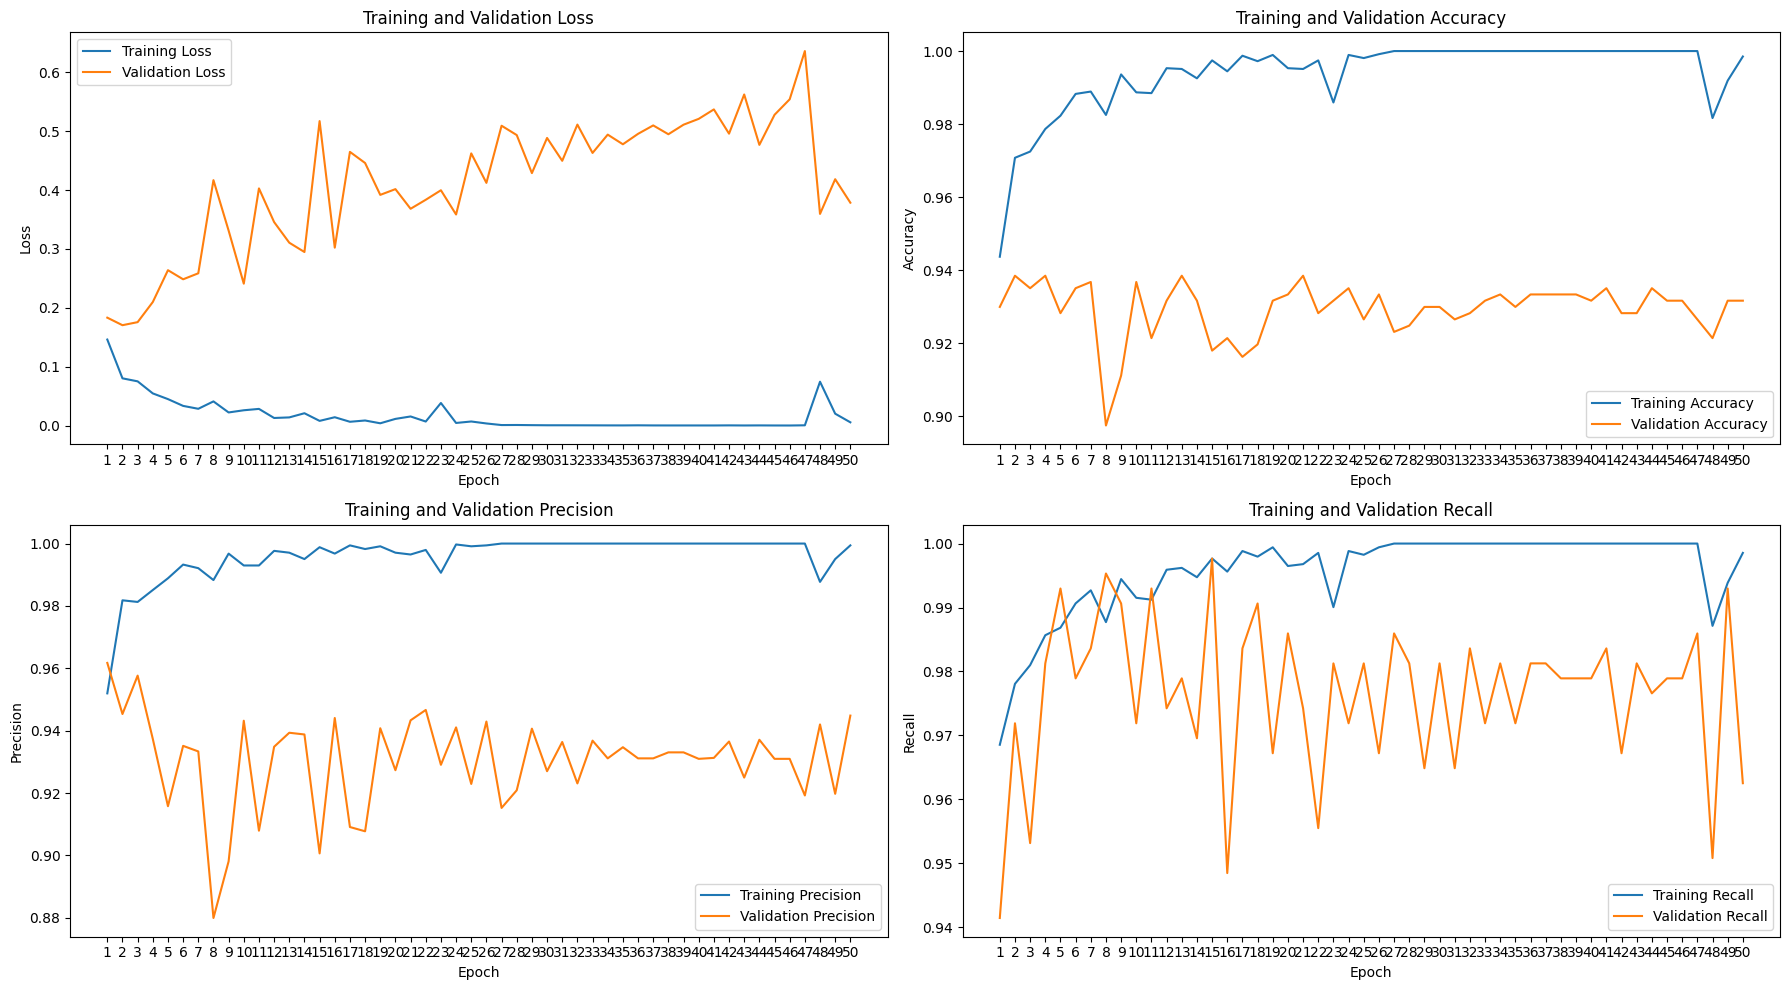

In [24]:
import matplotlib.pyplot as plt

# Assuming you have the 'history' object from model.fit()
epochs = range(1, len(final_history_test.history['loss']) + 1)

plt.figure(figsize=(18, 10))

# Plotting Training and Validation Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, final_history_test.history['loss'], label='Training Loss')
plt.plot(epochs, final_history_test.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()

# Plotting Training and Validation Accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, final_history_test.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, final_history_test.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend()

# Plotting Training and Validation Precision
plt.subplot(2, 2, 3)
plt.plot(epochs, final_history_test.history['precision'], label='Training Precision')
plt.plot(epochs, final_history_test.history['val_precision'], label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.xticks(epochs)
plt.legend()

# Plotting Training and Validation Recall
plt.subplot(2, 2, 4)
plt.plot(epochs, final_history_test.history['recall'], label='Training Recall')
plt.plot(epochs, final_history_test.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.xticks(epochs)
plt.legend()

# Add similar sections for other metrics like F1 Score, AUC, etc., replacing 'METRIC_NAME' with actual metric names

plt.tight_layout()
plt.show()


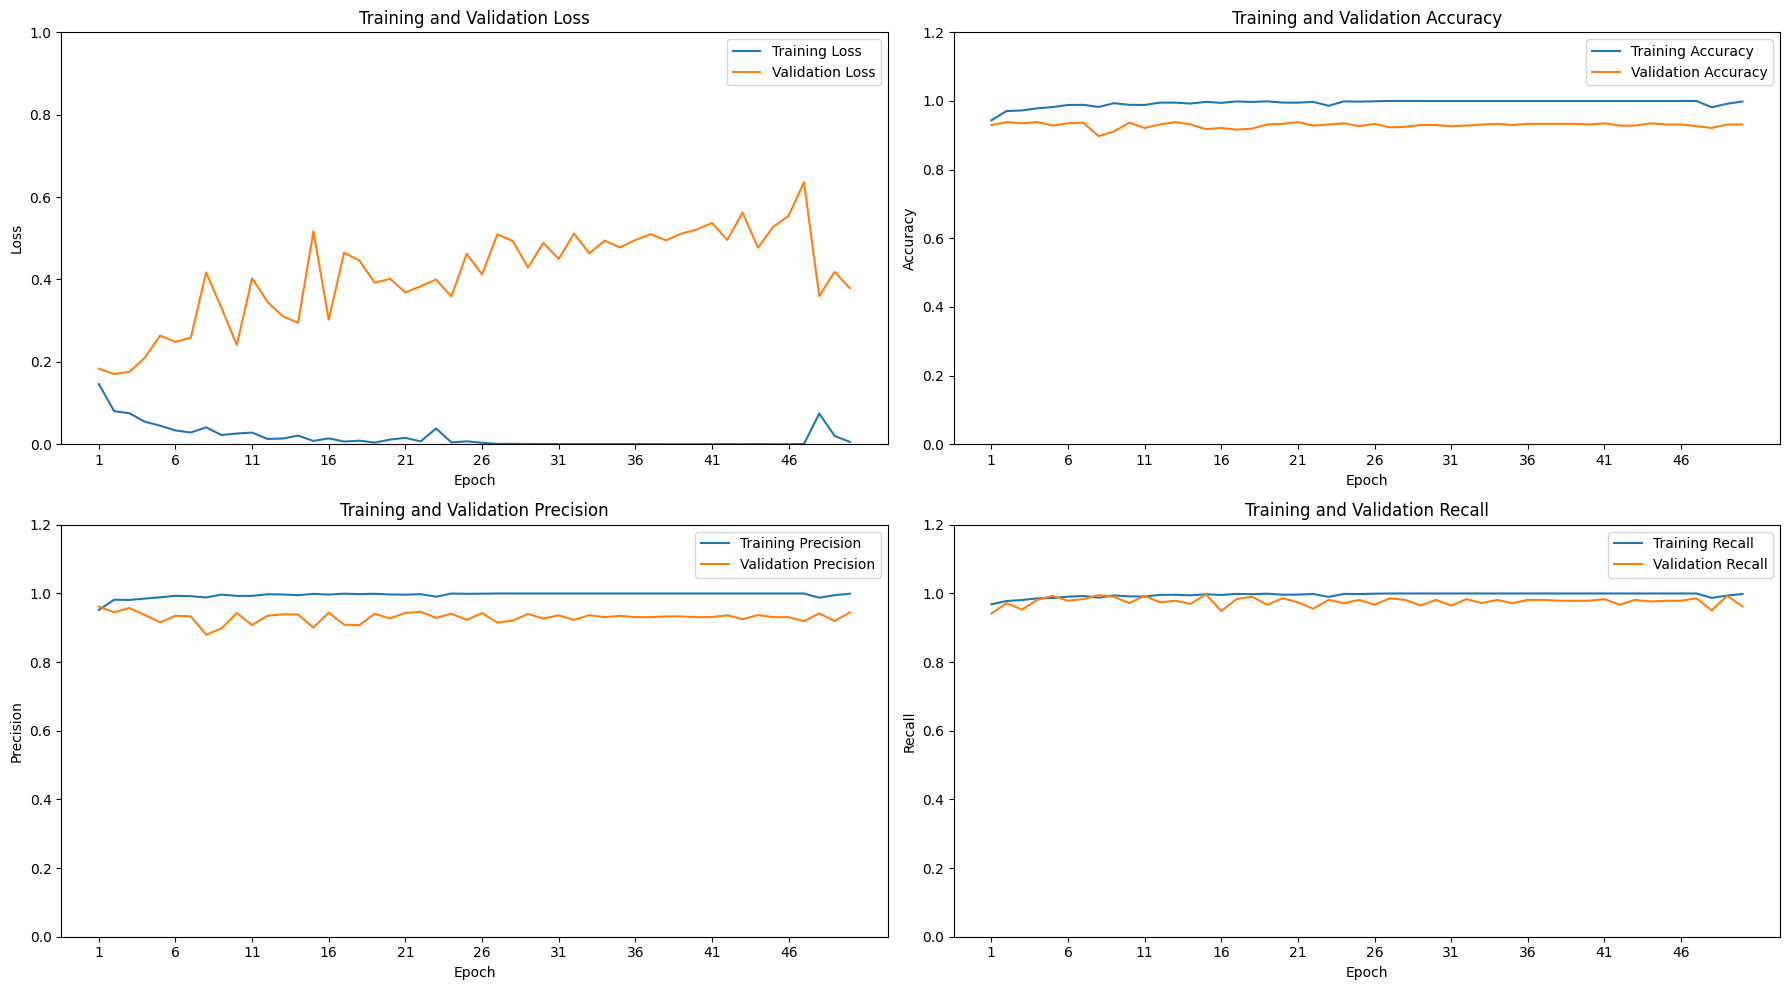

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the 'history' object from model.fit()
epochs = range(1, len(final_history_test.history['loss']) + 1)

plt.figure(figsize=(18, 10))

# Plotting Training and Validation Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, final_history_test.history['loss'], label='Training Loss')
plt.plot(epochs, final_history_test.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(1, len(epochs)+1, 5))  # Set ticks at every 5 epochs
plt.ylim(0, 1)  # Set y-axis limit to start at 0
plt.legend()

# Plotting Training and Validation Accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, final_history_test.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, final_history_test.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(np.arange(1, len(epochs)+1, 5))  # Set ticks at every 5 epochs
plt.ylim(0, 1.2)  # Set y-axis limit to start at 0
plt.legend()

# Plotting Training and Validation Precision
plt.subplot(2, 2, 3)
plt.plot(epochs, final_history_test.history['precision'], label='Training Precision')
plt.plot(epochs, final_history_test.history['val_precision'], label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.xticks(np.arange(1, len(epochs)+1, 5))  # Set ticks at every 5 epochs
plt.ylim(0, 1.2)  # Set y-axis limit to start at 0
plt.legend()

# Plotting Training and Validation Recall
plt.subplot(2, 2, 4)
plt.plot(epochs, final_history_test.history['recall'], label='Training Recall')
plt.plot(epochs, final_history_test.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.xticks(np.arange(1, len(epochs)+1, 5))  # Set ticks at every 5 epochs
plt.ylim(0, 1.2)  # Set y-axis limit to start at 0
plt.legend()

# Add similar sections for other metrics like F1 Score, AUC, etc., replacing 'METRIC_NAME' with actual metric names

plt.tight_layout()
plt.show()
